In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import special
from tqdm import tqdm
from matplotlib.colors import LogNorm
from astropy.table import Table
from scipy import stats


np.random.seed(0)

%matplotlib inline

100%|██████████| 3547/3547 [00:00<00:00, 14813.91it/s]


Estimator mean: 1.00, median: 0.01, std. dev.: 17.64


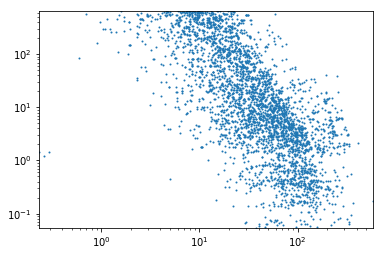

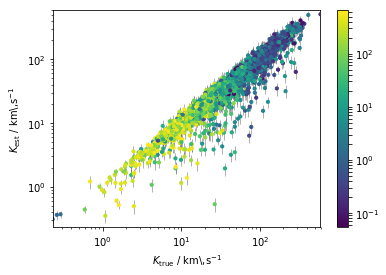

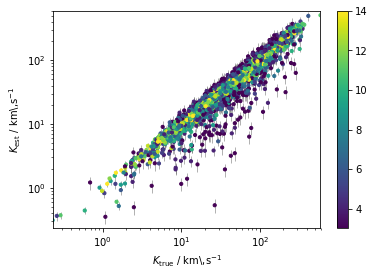

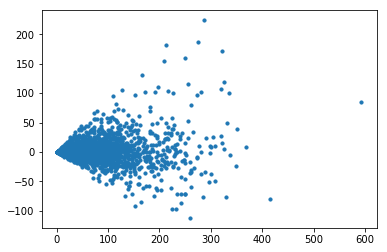

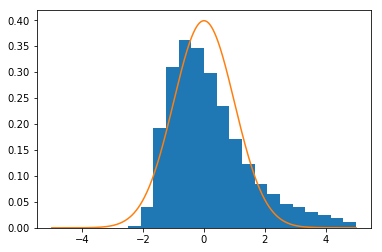

In [49]:
observing_span = 668 # u.days

sb9 = Table.read("../data/catalogs/sb9-pourbaix-et-al-orbits.fits")
P_true = np.array(sb9["Per"])
K_true = np.array(sb9["K1"])

# Let's simplify to things where we observe over the entire period 
keep = np.isfinite(K_true * P_true) \
     * (observing_span > P_true)
P_true, K_true = (P_true[keep], K_true[keep])

N_simulations = len(P_true)

varphi_true = np.random.uniform(0, 2 * np.pi, size=N_simulations)

# number of observations, and random observing times
# for now let's require > 30 obs
Ns = (250 * np.ones(N_simulations)).astype(int)
Ns = np.random.randint(3, 15, size=N_simulations)
times = np.random.uniform(0, observing_span, size=(N_simulations, max(Ns)))

v_sys_true = np.random.normal(0, 100, size=N_simulations)

radial_velocity = lambda t, P, K, varphi=0: K * np.sin(2 * np.pi * t / P + varphi)

K_est = np.zeros_like(K_true)
K_est_err = np.zeros_like(K_true)

V_rms = np.zeros_like(K_true)
V_std = np.zeros_like(K_true)

for i, (P, K, varphi, N, t_) \
in enumerate(tqdm(zip(P_true, K_true, varphi_true, Ns, times), total=N_simulations)):
    
    t = t_[:N]
    v = v_sys_true[i] + radial_velocity(t, P, K, varphi)
    v += np.random.normal(0, 0.1, size=v.size)

    V_rms[i] = np.sqrt(np.sum(v**2)/N)
    V_std[i] = np.sqrt(np.sum((v - np.mean(v))**2)/(N-1))


    K_est[i] = np.sqrt(2) * V_std[i]
    K_est_err[i] = V_std[i] / np.sqrt(2) * np.sqrt(1 - (2/(N-1)) * (special.gamma(N/2)/special.gamma((N-1)/2))**2)



fig, ax = plt.subplots()
ax.scatter(K_true, P_true, s=1)
ax.loglog()

ax.set_xlim(np.min(K_true), np.max(K_true))
ax.set_ylim(np.min(P_true), np.max(P_true))


fig, ax = plt.subplots()
scat = ax.scatter(K_true, K_est, c=P_true, norm=LogNorm(), s=10)
ax.errorbar(K_true, K_est, yerr=K_est_err, fmt="none", ecolor="#666666", zorder=-1, lw=0.5)
ax.set_xlabel(r"$K_\mathrm{true}$ / km\,s$^{-1}$")
ax.set_ylabel(r"$K_\mathrm{est}$ / km\,s$^{-1}$")
ax.loglog()

limits = np.vstack([K_true, K_est]).flatten()
limits = (np.min(limits), np.max(limits))

ax.set_xlim(limits)
ax.set_ylim(limits)    

cbar = plt.colorbar(scat)


fig, ax = plt.subplots()
scat = ax.scatter(K_true, K_est, c=Ns, s=10)
ax.errorbar(K_true, K_est, yerr=K_est_err, fmt="none", ecolor="#666666", zorder=-1, lw=0.5)
ax.set_xlabel(r"$K_\mathrm{true}$ / km\,s$^{-1}$")
ax.set_ylabel(r"$K_\mathrm{est}$ / km\,s$^{-1}$")
ax.loglog()

limits = np.vstack([K_true, K_est]).flatten()
limits = (np.min(limits), np.max(limits))

ax.set_xlim(limits)
ax.set_ylim(limits)    

cbar = plt.colorbar(scat)

diff = K_true - K_est
print(f"Estimator mean: {np.mean(diff):.2f}, median: {np.median(diff):.2f}, std. dev.: {np.std(diff):.2f}")



fig, ax = plt.subplots()
ax.scatter(K_true, diff, s=10)

Q = (K_true - K_est)/K_est_err

fig, ax = plt.subplots()
ax.hist(Q, bins=np.linspace(-5, 5, 25), normed=True)
xi = np.linspace(-5, 5, 1000)
from scipy import stats
yi = stats.norm.pdf(xi, 0, 1)

ax.plot(xi, yi)


# Let's consider the effect of large intrinsic errors per transit

100%|██████████| 3547/3547 [00:00<00:00, 11708.51it/s]


0 3547 -26.70 -27.77
1 2324 -7.73 -8.12


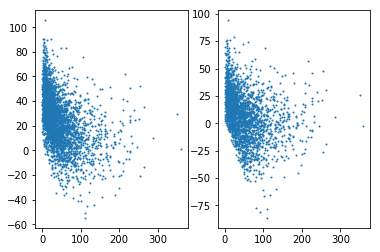

In [50]:

np.random.seed(0)
intrinsic_error_per_obs = 50 # km/s

vals = np.zeros((N_simulations, 3))

for i, (P, K, varphi, N, t_) \
in enumerate(tqdm(zip(P_true, K_true, varphi_true, Ns, times), total=N_simulations)):
    
    t = t_[:N]
    v_true = v_sys_true[i] + radial_velocity(t, P, K, varphi)
    noise = np.random.normal(0, intrinsic_error_per_obs, size=v_true.size)
    v_obs = v_true + noise
    
    # Calc stds
    std_true = np.sqrt(np.sum((v_true - np.mean(v_true))**2/(N-1)))

    std_obs = np.sqrt(np.sum((v_obs - np.mean(v_obs))**2/(N-1)))
    
    std_corrected = np.sqrt(std_obs**2 - intrinsic_error_per_obs**2)
    
    vals[i, :] = [std_true, std_obs, std_corrected]
    #print(f"{P: >10.1f} {K: >5.1f} {N: >3.0f} std_true: {std_true: >5.1f} std_obs: {std_obs: >5.1f}")
    #raise a
    
kw = dict(s=1)
fig, axes = plt.subplots(1, 2)
axes[0].scatter(vals.T[0], vals.T[1] - vals.T[0], **kw)
axes[1].scatter(vals.T[0], vals.T[2] - vals.T[0], **kw)

for i in range(2):
    diff = vals.T[0] - vals.T[i + 1]
    print(f"{i} {np.sum(np.isfinite(diff))} {np.nanmean(diff): >5.2f} {np.nanmedian(diff): >5.2f}")


100%|██████████| 3547/3547 [00:00<00:00, 11135.73it/s]


Estimator mean: 1.00, median: 0.03, std. dev.: 17.64 (N = 3547)
Q: 0.09 and 0.71


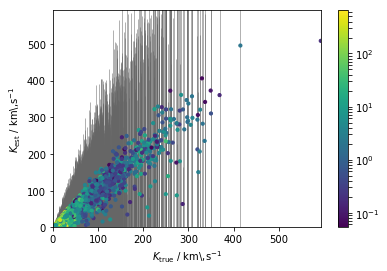

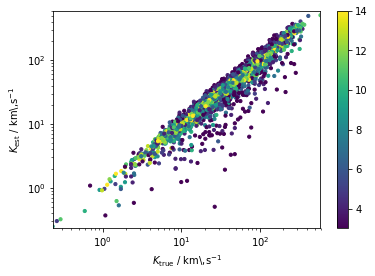

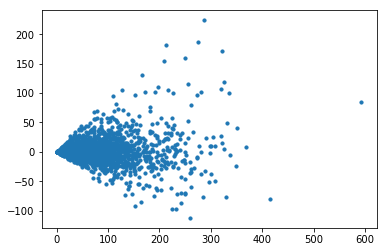

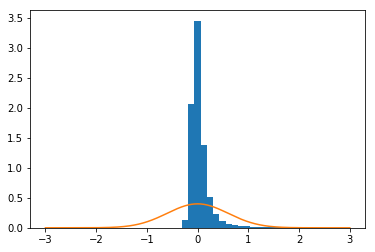

In [65]:
np.random.seed(0)

intrinsic_error_per_obs = 1e-5 # km/s

LE_K_est = np.zeros_like(K_true)
LE_K_est_err = np.zeros_like(K_true)

LE_V_rms = np.zeros_like(K_true)
LE_V_std = np.zeros_like(K_true)

for i, (P, K, varphi, N, t_) \
in enumerate(tqdm(zip(P_true, K_true, varphi_true, Ns, times), total=N_simulations)):
    
    t = t_[:N]
    v = v_sys_true[i] + radial_velocity(t, P, K, varphi)
    noise = np.random.normal(0, intrinsic_error_per_obs, size=v.size)
    v += noise

    LE_V_rms[i] = np.sqrt(np.sum(v**2)/N)
    LE_V_std[i] = np.sqrt(np.sum((v - np.mean(v))**2)/(N-1))
    
    sum_noise = np.sum(noise**2)/N
    #print(LE_V_std[i], sum_noise)
    # Correct the std given the assumed intrinsic error.
    #var_intrinsic = np.sum(intrinsic_error_per_obs**2/N)**2
    LE_V_std[i] = (LE_V_std[i]**2 - intrinsic_error_per_obs**2)**0.5
    
    
    # 
    # https://stats.stackexchange.com/questions/631/standard-deviation-of-standard-deviation
        
    # https://stats.stackexchange.com/questions/11707/why-is-sample-standard-deviation-a-biased-estimator-of-sigma/27984#27984
    
    # This works best so far:
    LE_K_est[i] = np.sqrt(2) * LE_V_std[i]
    
    
    #LE_K_est_err[i] = (LE_K_est[i]/2) * np.sqrt(1/(N-1)) * special.gamma(N/2)/special.gamma((N-1)/2)
    #LE_K_est_err[i] = np.sqrt(2) * LE_V_std[i] * np.sqrt(1 - (2/(N-1)) * (special.gamma(N/2)/special.gamma((N-1)/2))**2)
    factor = np.sqrt((N-1)/2) * special.gamma((N-1)/2)/special.gamma(N/2)
    LE_K_est_err[i] = LE_K_est[i] * np.sqrt(2) * factor
    
    # Bootstrap it!
    
    '''
    L = 500
    vals = np.zeros(L, dtype=float)
    
    for j in range(L):
        
        v = np.random.normal(0, intrinsic_error_per_obs, size=N)
        std = np.sqrt(np.sum((v)**2)/(v.size-1))
        vals[j] = np.sqrt(2) * std
        
    #print(N, np.std(vals), intrinsic_error_per_obs, np.sqrt(2) * np.sqrt(np.sum(intrinsic_error_per_obs**2)/(N-1)))
        
    #print(np.var(2 * vals), ((np.sqrt(2) * intrinsic_error_per_obs))**2/N)
    #print(np.std(vals), intrinsic_error_per_obs)
    
    foo = np.sqrt(2) * np.sqrt(N * intrinsic_error_per_obs**2/(N-1))
    '''
    
    #print(foo, np.std(vals))
    
    #LE_K_est_err[i] = np.sqrt(LE_K_est_err[i]**2 + np.var(2 * vals))
    #foo = np.sqrt((N * intrinsic_error_per_obs**2)/(N-1)) * 2 #/ (np.sqrt(2)/2)
    #foo = np.sqrt((N * intrinsic_error_per_obs**2)/(N-1))
    #LE_K_est_err[i] = np.sqrt(LE_K_est_err[i]**2 + foo**2)
    
    
    # at +/- 50 km/s:
    # 3.2: vals
    # 2.35: sqrt(2) * vals
    # 1.70: 2 * vals
    # 1.22: 2 * np.sqrt(2) * vals
    
    

fig, ax = plt.subplots()
scat = ax.scatter(K_true, LE_K_est, c=P_true, norm=LogNorm(), s=10)
ax.errorbar(K_true, LE_K_est, yerr=LE_K_est_err, fmt="none", ecolor="#666666", zorder=-1, lw=0.5)
ax.set_xlabel(r"$K_\mathrm{true}$ / km\,s$^{-1}$")
ax.set_ylabel(r"$K_\mathrm{est}$ / km\,s$^{-1}$")
#ax.loglog()

limits = np.vstack([K_true, LE_K_est]).flatten()
limits = (np.nanmin(limits), np.nanmax(limits))

ax.set_xlim(limits)
ax.set_ylim(limits)    

cbar = plt.colorbar(scat)


fig, ax = plt.subplots()
scat = ax.scatter(K_true, LE_K_est, c=Ns, s=10)
ax.errorbar(K_true, LE_K_est, yerr=LE_K_est_err, fmt="none", ecolor="#666666", zorder=-1, lw=0.5)
ax.set_xlabel(r"$K_\mathrm{true}$ / km\,s$^{-1}$")
ax.set_ylabel(r"$K_\mathrm{est}$ / km\,s$^{-1}$")
ax.loglog()

limits = np.vstack([K_true, LE_K_est]).flatten()
limits = (np.nanmin(limits), np.nanmax(limits))

ax.set_xlim(limits)
ax.set_ylim(limits)    

cbar = plt.colorbar(scat)

diff = K_true - LE_K_est
print(f"Estimator mean: {np.nanmean(diff):.2f}, median: {np.nanmedian(diff):.2f}, std. dev.: {np.nanstd(diff):.2f} (N = {np.sum(np.isfinite(diff))})")



fig, ax = plt.subplots()
ax.scatter(K_true, diff, s=10)

Q = (K_true - LE_K_est)/LE_K_est_err
ok = np.isfinite(Q)

fig, ax = plt.subplots()
ax.hist(Q[ok], bins=np.linspace(-3, 3, 50), normed=True)
xi = np.linspace(-3, 3, 1000)
ax.plot(xi, yi)

print(f"Q: {np.nanmean(Q):1.2f} and {np.nanstd(Q):1.2f}")

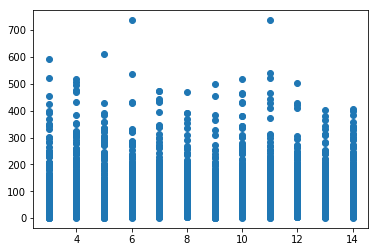

In [61]:
fig, ax = plt.subplots()
ax.scatter(Ns, LE_K_est_err)

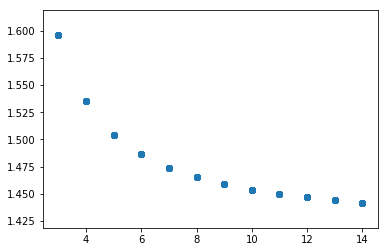

In [57]:
#ys = np.sqrt(1 - (2/(Ns-1)) * (special.gamma(Ns/2)/special.gamma((Ns-1)/2))**2)
ys = 1 * np.sqrt(Ns-1) * special.gamma((Ns-1)/2)/special.gamma(Ns/2)
fig, ax = plt.subplots()
ax.scatter(Ns, ys)

In [ ]:
%debug

In [ ]:
np.sqrt(np.sum(N * intrinsic_error_per_obs**2/(N-1)))

In [ ]:
var_intrinsic